# IMDb Data Analysis with SQL and Python

## Introduction

In this project we will analyze IMDb data taken from the official website and attempt to draw meaningful insights based on that information. The datasets we will be using here are _title.basics.tsv.gz_ and _title.ratings.tsv.gz_ which were taken from https://www.imdb.com/interfaces/ on 1/22/2020 and then imported into a SQLite database titled _IMDb.db_.

We will start by focusing our interest towards analyzing blockbuster movies from 2019 and evaluating the overall distribution of ratings given. We will then analyze genre popularity among film makers by analyzing genre frequencies and compare this to genre popularity among viewers by analyzing average genre ratings. The goal is to determine if there is a relationship between average genre ratings and how likely film makers are to release movies of a certain genre. Afterwards, we will transition into a multi-year analysis and analyze these metrics for the past decade.

We will be using SQL as our primary data anlysis tool with Python for data visualization and calculations.

## Importing Libraries and Setting Up

We will be utilizing SQL commands through the Python libraries `sqlite3` and `pandas`. The `numpy` library will be used for calculations, while `matplotlib` and `seaborn` will be used for data visualization. Finally, the `scipy.stats` library will be used for statistical testing.

A connection object must first be made to represent the database. This connection object will be used with `pd.read_sql()` to read SQL statements into a DataFrame, which can then be viewed or manipulated.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from scipy import stats

conn = sqlite3.connect('IMDb.db')

## Overview of Database Schema

Let's begin by examining the schema of our database.


In [2]:
tables = pd.read_sql("""
SELECT *
FROM sqlite_master
WHERE type = 'table';
""", conn)

tables

,type,name,tbl_name,rootpage,sql
0,table,title_basics_data,title_basics_data,2,"CREATE TABLE ""title_basics_data"" (\n\t""tconst""..."
1,table,title_ratings_data,title_ratings_data,144617,"CREATE TABLE ""title_ratings_data"" (\n\t""tconst..."


Our database contains two tables. `title_basics_data` contains basic information for each film, while `title_ratings_data` contains rating information for films that have been rated by users.

## Overview of Tables

Now we would like to examine each individual table within the database.

In [3]:
title_basics_overview = pd.read_sql("""
SELECT *
FROM title_basics_data
LIMIT 5;
""", conn)

title_basics_overview

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,\N,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [4]:
title_ratings_overview = pd.read_sql("""
SELECT *
FROM title_ratings_data
LIMIT 5;
""", conn)

title_ratings_overview

,tconst,averageRating,numVotes
0,tt0000001,5.6,1575
1,tt0000002,6.1,189
2,tt0000003,6.5,1239
3,tt0000004,6.2,117
4,tt0000005,6.1,1981


## Modifying the Data

Since we are interested in 2019 blockbuster movies, we must first select for movies in our queries. To do so, we must view all distinct title types and determine the various types of categories.

In [5]:
distinct_title_types = pd.read_sql("""
SELECT DISTINCT titleType
FROM title_basics_data;
""", conn)

distinct_title_types

,titleType
0,short
1,movie
2,tvMovie
3,tvSeries
4,tvEpisode
5,tvShort
6,tvMiniSeries
7,tvSpecial
8,video
9,videoGame


The above query shows that the only category we are interested in is the `movie` category.

Unfortunately, there is no "blockbuster movie" category, thus we will have to attempt to filter for only blockbuster titles. To do this, we will limit our query to 2019 movies with at least 10,000 ratings. This number was chosen through trial and error to limit the number of smaller, independent movies, while still trying to select for some of the less popular blockbuster movies.

In [6]:
blockbuster_movies_2019 = pd.read_sql("""
SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
FROM title_basics_data AS 'tb'
JOIN title_ratings_data AS 'tr'
    ON tb.tconst = tr.tconst
WHERE titleType = 'movie'
    AND startYear = 2019
    AND numVotes >= 10000
ORDER BY averageRating DESC;
""", conn)

blockbuster_movies_2019

,tconst,primaryTitle,startYear,genres,averageRating,numVotes
0,tt6751668,Parasite,2019,"Comedy,Crime,Drama",8.6,159446
1,tt7286456,Joker,2019,"Crime,Drama,Thriller",8.6,622678
2,tt8579674,1917,2019,"Drama,War",8.6,73360
3,tt4154796,Avengers: Endgame,2019,"Action,Adventure,Drama",8.5,650218
4,tt8291224,Uri: The Surgical Strike,2019,"Action,Drama,War",8.4,36694
...,...,...,...,...,...,...
165,tt5033998,Charlie's Angels,2019,"Action,Adventure,Comedy",4.2,17757
166,tt5913798,Wounds,2019,"Drama,Horror,Mystery",4.1,10820
167,tt7825208,Marighella,2019,"Action,Drama,History",3.0,42321
168,tt5697572,Cats,2019,"Comedy,Drama,Family",2.8,23213


The resulting DataFrame contains 170 movies with largely recognizable titles. Let's clean up the data and split the `genres` column using subqueries and common table expressions. `CASE` statements are necessary to maintain the ordering of genres.

In [7]:
clean_blockbuster_movies_2019 = pd.read_sql("""
WITH blockbuster_movies_2019 AS (
    SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
    FROM title_basics_data AS 'tb'
    JOIN title_ratings_data AS 'tr'
        ON tb.tconst = tr.tconst
    WHERE titleType = 'movie'
        AND startYear = 2019
        AND numVotes >= 10000
    ORDER BY averageRating DESC
),
clean_blockbuster_movies_2019 AS (
    SELECT tconst AS 'title_id', primaryTitle AS 'primary_title', startYear AS 'year',
        averageRating AS 'average_rating', numVotes AS 'num_votes', genre_1,
        CASE
            WHEN INSTR(genre_2_3, ',') = 0 THEN genre_2_3
            ELSE SUBSTR(genre_2_3, 1, INSTR(genre_2_3, ',') - 1)
        END AS 'genre_2',
        CASE
            WHEN INSTR(genre_2_3, ',') > 0 THEN SUBSTR(genre_2_3, INSTR(genre_2_3, ',') + 1)
        END AS 'genre_3'
    FROM (
        SELECT blockbuster_movies_2019.*,
            CASE
                WHEN INSTR(genres, ',') = 0 THEN genres
                ELSE SUBSTR(genres, 1, INSTR(genres, ',') - 1)
            END AS 'genre_1',
            CASE
                WHEN INSTR(genres, ',') >0 THEN SUBSTR(genres, INSTR(genres, ',') + 1)
            END AS 'genre_2_3'
    FROM blockbuster_movies_2019
    )
)
SELECT *
FROM clean_blockbuster_movies_2019;
""", conn)

clean_blockbuster_movies_2019

,title_id,primary_title,year,average_rating,num_votes,genre_1,genre_2,genre_3
0,tt6751668,Parasite,2019,8.6,159446,Comedy,Crime,Drama
1,tt7286456,Joker,2019,8.6,622678,Crime,Drama,Thriller
2,tt8579674,1917,2019,8.6,73360,Drama,War,None
3,tt4154796,Avengers: Endgame,2019,8.5,650218,Action,Adventure,Drama
4,tt8291224,Uri: The Surgical Strike,2019,8.4,36694,Action,Drama,War
...,...,...,...,...,...,...,...,...
165,tt5033998,Charlie's Angels,2019,4.2,17757,Action,Adventure,Comedy
166,tt5913798,Wounds,2019,4.1,10820,Drama,Horror,Mystery
167,tt7825208,Marighella,2019,3.0,42321,Action,Drama,History
168,tt5697572,Cats,2019,2.8,23213,Comedy,Drama,Family


This DataFrame contains our 2019 blockbuster movies rated from best to worst by IMDb users, with the visualization showing the top 5 and bottom 5 rated movies.

We will be utilizing this common table expression (`clean_blockbuster_movies_2019`) as the basis for much of our future analyses.

## Analysis and Visualization of Ratings

Now that our data is ready to use, we can begin analyzing and visualizing the ratings data. We'll begin by plotting a histogram and a box plot of the data.

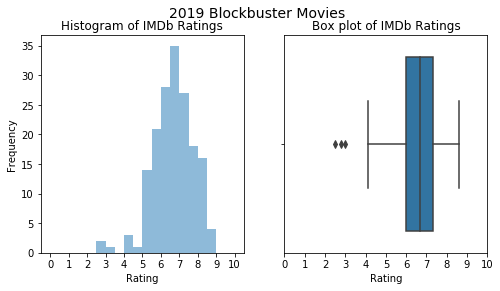

In [8]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('2019 Blockbuster Movies', fontsize=14)

ax1.hist(clean_blockbuster_movies_2019.average_rating, range=(0, 10), bins=20, alpha=0.5)
ax1.set_xticks(range(11))
ax1.set_xlabel('Rating')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of IMDb Ratings')

sns.boxplot(x=clean_blockbuster_movies_2019.average_rating, ax=ax2)
ax2.set_title('Box plot of IMDb Ratings')
ax2.set_xticks(range(11))
ax2.set_xlabel('Rating')

plt.show()

Now we'll calculate some basic statistics for our dataset.

In [9]:
print("The mean of our dataset is {0}".format(np.mean(clean_blockbuster_movies_2019.average_rating)))
print("The standard deviation of our dataset is {0}".format(np.std(clean_blockbuster_movies_2019.average_rating)))
print("")
print("The minimum value of our dataset is {0}".format(np.amin(clean_blockbuster_movies_2019.average_rating)))
print("The first quartile of our dataset is {0}".format(np.quantile(clean_blockbuster_movies_2019.average_rating, 0.25)))
print("The median of our dataset is {0}".format(np.median(clean_blockbuster_movies_2019.average_rating)))
print("The third quartile of our dataset is {0}".format(np.quantile(clean_blockbuster_movies_2019.average_rating, 0.75)))
print("The maximum value of our dataset is {0}".format(np.amax(clean_blockbuster_movies_2019.average_rating)))

The mean of our dataset is 6.613529411764708
The standard deviation of our dataset is 1.072322609360967

The minimum value of our dataset is 2.5
The first quartile of our dataset is 6.0
The median of our dataset is 6.7
The third quartile of our dataset is 7.3
The maximum value of our dataset is 8.6


The above shows that our data appears normally distributed with an average of about 6.61 and a standard deviation of about 1.07. Half of the data falls between 6.0 and 7.3, with the highest value being 8.6 and the lowest value being 2.5.

## Analysis and Visualization of Genres

We will now attempt to compare genre popularity among film makers to that of viewers in order to see if there is a relationship between the two. We will be using genre frequency counts as a measure of genre popularity among film makers and average genre ratings as a measure of genre popularity among viewers.

To begin, we will gather and count all genres and visualize the data as a bar graph.

In [10]:
count_genres_blockbuster_movies_2019 = pd.read_sql("""
WITH blockbuster_movies_2019 AS (
    SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
    FROM title_basics_data AS 'tb'
    JOIN title_ratings_data AS 'tr'
        ON tb.tconst = tr.tconst
    WHERE titleType = 'movie'
        AND startYear = 2019
        AND numVotes >= 10000
    ORDER BY averageRating DESC
),
clean_blockbuster_movies_2019 AS (
    SELECT tconst AS 'title_id', primaryTitle AS 'primary_title', startYear AS 'year',
        averageRating AS 'average_rating', numVotes AS 'num_votes', genre_1,
        CASE
            WHEN INSTR(genre_2_3, ',') = 0 THEN genre_2_3
            ELSE SUBSTR(genre_2_3, 1, INSTR(genre_2_3, ',') - 1)
        END AS 'genre_2',
        CASE
            WHEN INSTR(genre_2_3, ',') > 0 THEN SUBSTR(genre_2_3, INSTR(genre_2_3, ',') + 1)
        END AS 'genre_3'
    FROM (
        SELECT blockbuster_movies_2019.*,
            CASE
                WHEN INSTR(genres, ',') = 0 THEN genres
                ELSE SUBSTR(genres, 1, INSTR(genres, ',') - 1)
            END AS 'genre_1',
            CASE
                WHEN INSTR(genres, ',') >0 THEN SUBSTR(genres, INSTR(genres, ',') + 1)
            END AS 'genre_2_3'
    FROM blockbuster_movies_2019
    )
),
all_genres_blockbuster_movies_2019 AS (
    SELECT genre_1 AS 'genres'
    FROM clean_blockbuster_movies_2019
    WHERE genre_1 IS NOT NULL
    UNION ALL
    SELECT genre_2
    FROM clean_blockbuster_movies_2019
    WHERE genre_2 IS NOT NULL
    UNION ALL
    SELECT genre_3
    FROM clean_blockbuster_movies_2019
    WHERE genre_3 IS NOT NULL
)
SELECT genres, COUNT(*) AS 'count'
FROM all_genres_blockbuster_movies_2019
GROUP BY 1
ORDER BY 2 DESC;
""", conn)

count_genres_blockbuster_movies_2019

,genres,count
0,Drama,89
1,Comedy,61
2,Action,46
3,Adventure,44
4,Horror,28
5,Crime,25
6,Thriller,22
7,Romance,22
8,Biography,22
9,Mystery,21


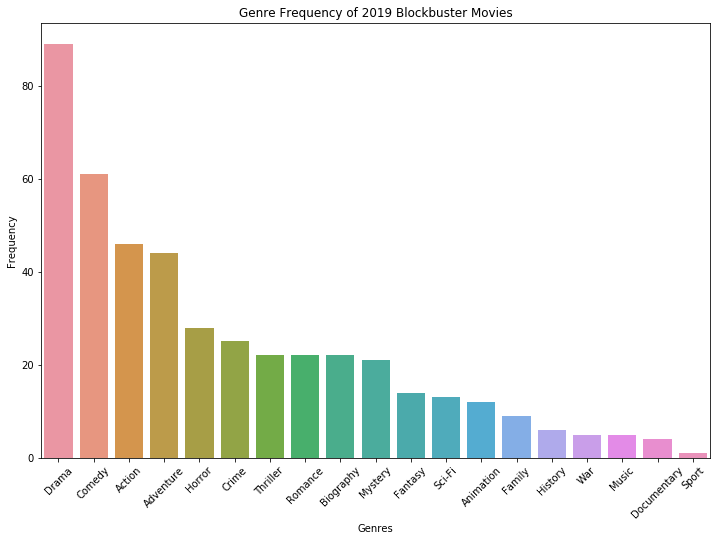

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=count_genres_blockbuster_movies_2019, x='genres', y='count')
plt.xticks(rotation=45)
ax.set_xlabel('Genres')
ax.set_ylabel('Frequency')
ax.set_title('Genre Frequency of 2019 Blockbuster Movies')
plt.show()

Now that we have the genre frequency counts that we need, the next step is to gather the average rating for each genre.

In [12]:
genre_ratings_blockbuster_movies_2019 = pd.read_sql("""
WITH blockbuster_movies_2019 AS (
    SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
    FROM title_basics_data AS 'tb'
    JOIN title_ratings_data AS 'tr'
        ON tb.tconst = tr.tconst
    WHERE titleType = 'movie'
        AND startYear = 2019
        AND numVotes >= 10000
    ORDER BY averageRating DESC
),
clean_blockbuster_movies_2019 AS (
    SELECT tconst AS 'title_id', primaryTitle AS 'primary_title', startYear AS 'year',
        averageRating AS 'average_rating', numVotes AS 'num_votes', genre_1,
        CASE
            WHEN INSTR(genre_2_3, ',') = 0 THEN genre_2_3
            ELSE SUBSTR(genre_2_3, 1, INSTR(genre_2_3, ',') - 1)
        END AS 'genre_2',
        CASE
            WHEN INSTR(genre_2_3, ',') > 0 THEN SUBSTR(genre_2_3, INSTR(genre_2_3, ',') + 1)
        END AS 'genre_3'
    FROM (
        SELECT blockbuster_movies_2019.*,
            CASE
                WHEN INSTR(genres, ',') = 0 THEN genres
                ELSE SUBSTR(genres, 1, INSTR(genres, ',') - 1)
            END AS 'genre_1',
            CASE
                WHEN INSTR(genres, ',') >0 THEN SUBSTR(genres, INSTR(genres, ',') + 1)
            END AS 'genre_2_3'
    FROM blockbuster_movies_2019
    )
),
union_genre_ratings_blockbuster_movies_2019 AS (
    SELECT genre_1 AS 'genres', AVG(average_rating) AS 'average_rating', COUNT(*) AS 'count'
    FROM clean_blockbuster_movies_2019
    WHERE genre_1 IS NOT NULL
    GROUP BY 1
    UNION ALL
    SELECT genre_2, AVG(average_rating), COUNT(*) AS 'count'
    FROM clean_blockbuster_movies_2019
    WHERE genre_2 IS NOT NULL
    GROUP BY 1
    UNION ALL
    SELECT genre_3, AVG(average_rating), COUNT(*) AS 'count'
    FROM clean_blockbuster_movies_2019
    WHERE genre_3 IS NOT NULL
    GROUP BY 1
)
SELECT genres, ROUND(AVG(average_rating), 2) AS 'average_rating', SUM(count) AS 'count'
FROM union_genre_ratings_blockbuster_movies_2019
GROUP BY 1
ORDER BY 2 DESC;
""", conn)

genre_ratings_blockbuster_movies_2019

,genres,average_rating,count
0,War,7.99,5
1,Music,7.38,5
2,Documentary,7.35,4
3,Biography,7.33,22
4,Crime,6.97,25
5,Animation,6.95,12
6,Drama,6.87,89
7,History,6.75,6
8,Comedy,6.58,61
9,Adventure,6.57,44


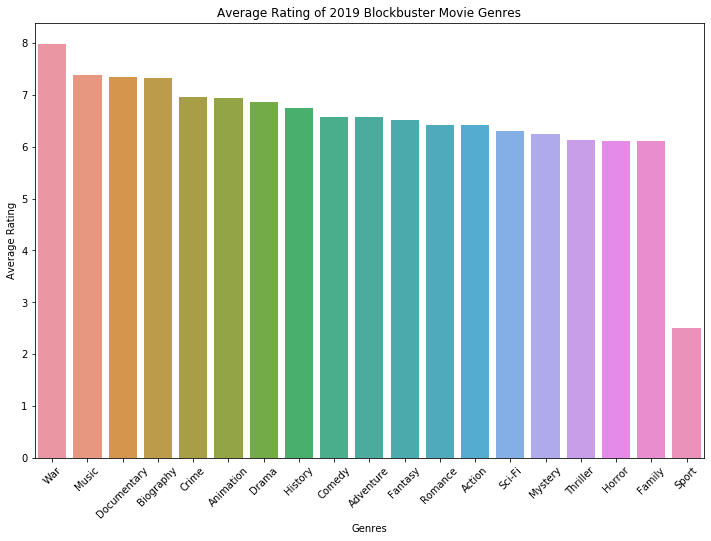

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=genre_ratings_blockbuster_movies_2019, x='genres', y='average_rating')
plt.xticks(rotation=45)
ax.set_xlabel('Genres')
ax.set_ylabel('Average Rating')
ax.set_title('Average Rating of 2019 Blockbuster Movie Genres')
plt.show()

We can now see how genre popularity differs among film makers and viewers for 2019 blockbuster movies. The two appear fairly unrelated, however our population size for many of the genres is far too small to draw meaningful conclusions from.

Although these graphs may be an accurate visualization for 2019 blockbuster movies, they do not accurately show the true nature of blockbuster movie genres in general due to the population size issue previously mentioned. To better analyze blockbuster movie genres from a general point of view, we will transition into a multi-year analysis to gather more data.

## Multi-Year Analysis

We will begin by gathering data for our multi-year analysis. This query will be very similar to our intial query for 2019 blockbuster movies.

In [14]:
clean_blockbuster_movies_multi_year = pd.read_sql("""
WITH blockbuster_movies_multi_year AS (
    SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
    FROM title_basics_data AS 'tb'
    JOIN title_ratings_data AS 'tr'
        ON tb.tconst = tr.tconst
    WHERE titleType = 'movie'
        AND startYear BETWEEN 2010 AND 2019
        AND numVotes >= 10000
    ORDER BY averageRating DESC
),
clean_blockbuster_movies_multi_year AS (
    SELECT tconst AS 'title_id', primaryTitle AS 'primary_title', startYear AS 'year',
        averageRating AS 'average_rating', numVotes AS 'num_votes', genre_1,
        CASE
            WHEN INSTR(genre_2_3, ',') = 0 THEN genre_2_3
            ELSE SUBSTR(genre_2_3, 1, INSTR(genre_2_3, ',') - 1)
        END AS 'genre_2',
        CASE
            WHEN INSTR(genre_2_3, ',') > 0 THEN SUBSTR(genre_2_3, INSTR(genre_2_3, ',') + 1)
        END AS 'genre_3'
    FROM (
        SELECT blockbuster_movies_multi_year.*,
            CASE
                WHEN INSTR(genres, ',') = 0 THEN genres
                ELSE SUBSTR(genres, 1, INSTR(genres, ',') - 1)
            END AS 'genre_1',
            CASE
                WHEN INSTR(genres, ',') >0 THEN SUBSTR(genres, INSTR(genres, ',') + 1)
            END AS 'genre_2_3'
    FROM blockbuster_movies_multi_year
    ORDER BY 3
    )
)
SELECT *
FROM clean_blockbuster_movies_multi_year;
""", conn)

clean_blockbuster_movies_multi_year

,title_id,primary_title,year,average_rating,num_votes,genre_1,genre_2,genre_3
0,tt1375666,Inception,2010,8.8,1914224,Action,Adventure,Sci-Fi
1,tt1424432,Senna,2010,8.5,58052,Biography,Documentary,Sport
2,tt0435761,Toy Story 3,2010,8.3,714835,Adventure,Animation,Comedy
3,tt1255953,Incendies,2010,8.3,131587,Drama,Mystery,War
4,tt1634013,Montevideo: Taste of a Dream,2010,8.2,10753,Adventure,Comedy,Drama
...,...,...,...,...,...,...,...,...
2882,tt5033998,Charlie's Angels,2019,4.2,17757,Action,Adventure,Comedy
2883,tt5913798,Wounds,2019,4.1,10820,Drama,Horror,Mystery
2884,tt7825208,Marighella,2019,3.0,42321,Action,Drama,History
2885,tt5697572,Cats,2019,2.8,23213,Comedy,Drama,Family


The resulting DataFrame contains 2887 blockbuster movies from 2010 - 2019 and ranks them in order of best to worst rated. Just as before, this query will be the basis for much of our future analyses.

To start, we will plot a histogram of each year's rating data on the same axis to see if we can spot any major outliers.

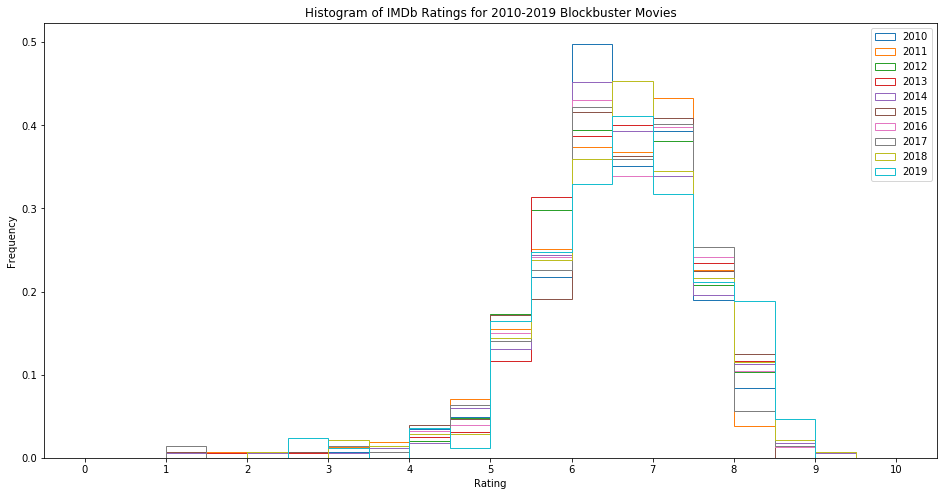

In [15]:
fig, ax = plt.subplots(figsize=(16, 8))
for i in range(2010, 2020):
    plt.hist(clean_blockbuster_movies_multi_year[clean_blockbuster_movies_multi_year.year == i]\
             .average_rating, range=(0, 10), bins=20, density=True, histtype='step', label=str(i))
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of IMDb Ratings for 2010-2019 Blockbuster Movies')
plt.legend()
plt.show()

The resulting graph shows that the years do not appear significantly different from each other, as it looks like they share a similar mean and standard deviation. To test this, we will run an ANOVA test with a significance level of 0.05.

In [16]:
a = []
for i in range(2010, 2020):
    a.append(clean_blockbuster_movies_multi_year[clean_blockbuster_movies_multi_year.year == i].average_rating)
print(stats.f_oneway(*a))

F_onewayResult(statistic=0.6904475171989084, pvalue=0.7182350359394707)


With a p-value of 0.718, we are unable to reject the null hypothesis that all of the datasets have the same mean.

In order to begin analyzing genre popularity among film makers, we must first gather genre percentile makeup data. We choose to analyze percentile makeup data instead of frequency data because different years will have different movie number totals, which would make relative analyses difficult unless the data is changed to percentages.

In [17]:
percentile_genres_blockbuster_movies_multi_year = pd.read_sql("""
WITH blockbuster_movies_multi_year AS (
    SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
    FROM title_basics_data AS 'tb'
    JOIN title_ratings_data AS 'tr'
        ON tb.tconst = tr.tconst
    WHERE titleType = 'movie'
        AND startYear BETWEEN 2010 AND 2019
        AND numVotes >= 10000
    ORDER BY averageRating DESC
),
clean_blockbuster_movies_multi_year AS (
    SELECT tconst AS 'title_id', primaryTitle AS 'primary_title', startYear AS 'year',
        averageRating AS 'average_rating', numVotes AS 'num_votes', genre_1,
        CASE
            WHEN INSTR(genre_2_3, ',') = 0 THEN genre_2_3
            ELSE SUBSTR(genre_2_3, 1, INSTR(genre_2_3, ',') - 1)
        END AS 'genre_2',
        CASE
            WHEN INSTR(genre_2_3, ',') > 0 THEN SUBSTR(genre_2_3, INSTR(genre_2_3, ',') + 1)
        END AS 'genre_3'
    FROM (
        SELECT blockbuster_movies_multi_year.*,
            CASE
                WHEN INSTR(genres, ',') = 0 THEN genres
                ELSE SUBSTR(genres, 1, INSTR(genres, ',') - 1)
            END AS 'genre_1',
            CASE
                WHEN INSTR(genres, ',') >0 THEN SUBSTR(genres, INSTR(genres, ',') + 1)
            END AS 'genre_2_3'
    FROM blockbuster_movies_multi_year
    ORDER BY 3
    )
),
all_genres_blockbuster_movies_multi_year AS (
    SELECT year, genre_1 AS 'genres', COUNT(*) AS 'count'
    FROM clean_blockbuster_movies_multi_year
    WHERE genre_1 IS NOT NULL
    GROUP BY 1, 2
    UNION ALL
    SELECT year, genre_2, COUNT(*)
    FROM clean_blockbuster_movies_multi_year
    WHERE genre_2 IS NOT NULL
    GROUP BY 1, 2
    UNION ALL
    SELECT year, genre_3, COUNT(*)
    FROM clean_blockbuster_movies_multi_year
    WHERE genre_3 IS NOT NULL
    GROUP BY 1, 2
    ORDER BY 1 ASC, 3 DESC
),
year_count_blockbuster_movies_multi_year AS (
    SELECT year, SUM(count) AS 'year_count'
    FROM all_genres_blockbuster_movies_multi_year
    GROUP BY 1
),
join_count_blockbuster_movies_multi_year AS (
    SELECT ag.year, ag.genres, SUM(ag.count) AS 'count', tc.year_count
    FROM all_genres_blockbuster_movies_multi_year AS 'ag'
    JOIN year_count_blockbuster_movies_multi_year AS 'tc'
        ON ag.year = tc.year
    GROUP BY 1, 2
    ORDER BY 1 ASC, 3 DESC
)
SELECT *, 1.0 * count / year_count AS 'percentile'
FROM join_count_blockbuster_movies_multi_year;
""", conn)

percentile_genres_blockbuster_movies_multi_year

,year,genres,count,year_count,percentile
0,2010,Drama,163,728,0.223901
1,2010,Comedy,109,728,0.149725
2,2010,Action,77,728,0.105769
3,2010,Romance,61,728,0.083791
4,2010,Crime,50,728,0.068681
...,...,...,...,...,...
204,2019,History,6,449,0.013363
205,2019,War,5,449,0.011136
206,2019,Music,5,449,0.011136
207,2019,Documentary,4,449,0.008909


The resulting DataFrame contains genres grouped by year and ordered by percentile makeup. We will use this to generate a line graph of genre percentile makeup over the past decade.

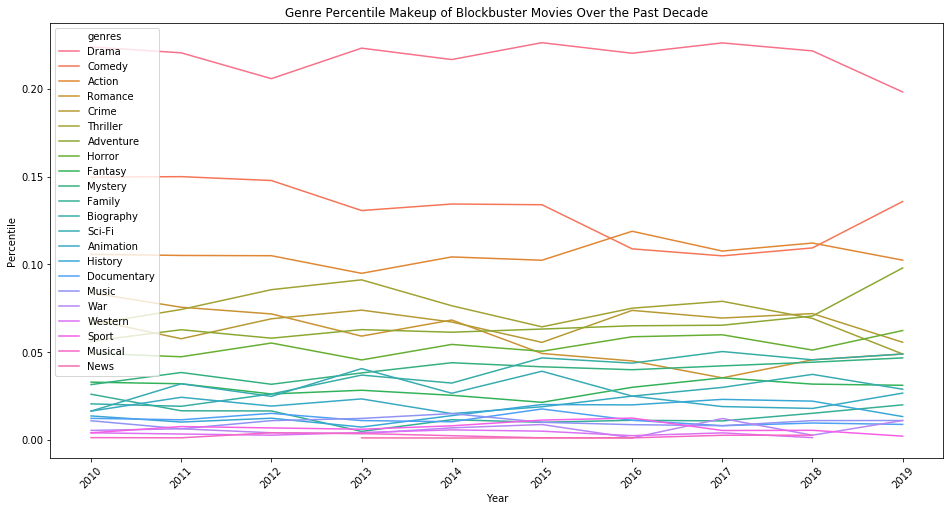

In [18]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(data=percentile_genres_blockbuster_movies_multi_year, x='year', y='percentile', hue='genres')
plt.xticks(rotation=45)
ax.set_xticks([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])
ax.set_xlabel('Year')
ax.set_ylabel('Percentile')
ax.set_title('Genre Percentile Makeup of Blockbuster Movies Over the Past Decade')
plt.show()

The graph above shows that genre popularity among film makers has stayed relatively similar over the years, with "Drama" being the most popular by far.

We will now modify the above query to include genre ratings by year to analyze genre popularity among viewers.

In [19]:
genre_ratings_blockbuster_movies_multi_year = pd.read_sql("""
WITH blockbuster_movies_multi_year AS (
    SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
    FROM title_basics_data AS 'tb'
    JOIN title_ratings_data AS 'tr'
        ON tb.tconst = tr.tconst
    WHERE titleType = 'movie'
        AND startYear BETWEEN 2010 AND 2019
        AND numVotes >= 10000
    ORDER BY averageRating DESC
),
clean_blockbuster_movies_multi_year AS (
    SELECT tconst AS 'title_id', primaryTitle AS 'primary_title', startYear AS 'year',
        averageRating AS 'average_rating', numVotes AS 'num_votes', genre_1,
        CASE
            WHEN INSTR(genre_2_3, ',') = 0 THEN genre_2_3
            ELSE SUBSTR(genre_2_3, 1, INSTR(genre_2_3, ',') - 1)
        END AS 'genre_2',
        CASE
            WHEN INSTR(genre_2_3, ',') > 0 THEN SUBSTR(genre_2_3, INSTR(genre_2_3, ',') + 1)
        END AS 'genre_3'
    FROM (
        SELECT blockbuster_movies_multi_year.*,
            CASE
                WHEN INSTR(genres, ',') = 0 THEN genres
                ELSE SUBSTR(genres, 1, INSTR(genres, ',') - 1)
            END AS 'genre_1',
            CASE
                WHEN INSTR(genres, ',') >0 THEN SUBSTR(genres, INSTR(genres, ',') + 1)
            END AS 'genre_2_3'
    FROM blockbuster_movies_multi_year
    ORDER BY 3
    )
),
union_genre_ratings_blockbuster_movies_multi_year AS (
    SELECT genre_1 AS 'genres', AVG(average_rating) AS 'average_rating', COUNT(*) AS 'count'
    FROM clean_blockbuster_movies_multi_year
    WHERE genre_1 IS NOT NULL
    GROUP BY 1
    UNION ALL
    SELECT genre_2, AVG(average_rating), COUNT(*) AS 'count'
    FROM clean_blockbuster_movies_multi_year
    WHERE genre_2 IS NOT NULL
    GROUP BY 1
    UNION ALL
    SELECT genre_3, AVG(average_rating), COUNT(*) AS 'count'
    FROM clean_blockbuster_movies_multi_year
    WHERE genre_3 IS NOT NULL
    GROUP BY 1
)
SELECT genres, ROUND(AVG(average_rating), 2) AS 'average_rating', SUM(count) AS 'count'
FROM union_genre_ratings_blockbuster_movies_multi_year
GROUP BY 1
ORDER BY 2 DESC;
""", conn)

genre_ratings_blockbuster_movies_multi_year

,genres,average_rating,count
0,News,7.95,4
1,Documentary,7.62,87
2,Biography,7.14,271
3,War,7.05,45
4,Animation,7.05,151
5,History,7.01,116
6,Sport,6.97,54
7,Western,6.75,20
8,Drama,6.75,1622
9,Music,6.70,78


The resulting DataFrame now contains the average rating of each genre as well. This will be used to create a bar graph of average genre ratings.

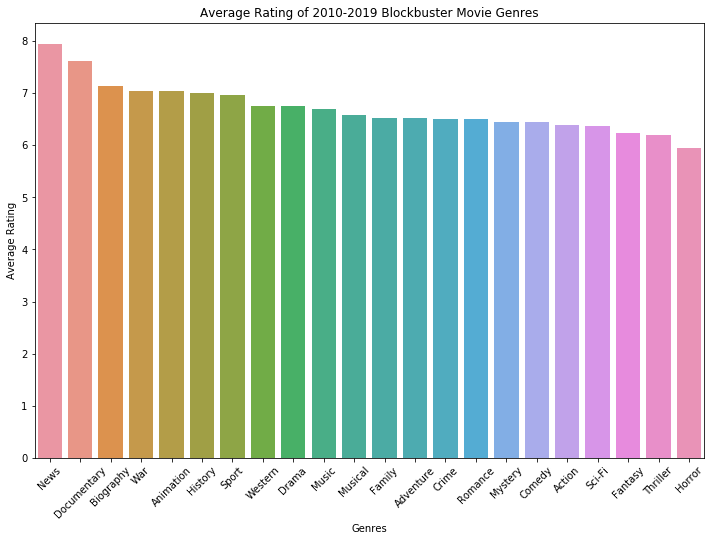

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=genre_ratings_blockbuster_movies_multi_year, x='genres', y='average_rating')
plt.xticks(rotation=45)
ax.set_xlabel('Genres')
ax.set_ylabel('Average Rating')
ax.set_title('Average Rating of 2010-2019 Blockbuster Movie Genres')
plt.show()

This graph shows us the overall genre rating for blockbuster movies from 2010 - 2019.

Using the average genre rating data from this graph and comparing with the genre percentile makeup data from the previous graph, it appears that there is minimal correlation between what is well rated and what film makers release. Drama is the most common movie genre by far, yet is ranked somewhat in the middle of genre ratings. Comedy, action, and romance follow drama as some of the most common movie genres, yet are typically ranked towards the lower end of the scale. In addition, horror is ranked as last place in terms of ratings, yet is a fairly common movie genre for film makers to release.

## Summary and Closing Thoughts

Although it appears that there is minimal correlation between what is well rated and what film makers release, we were still able to draw interesting insight regarding what genres viewers typically like, versus what is often released to theaters by film makers.

We would also like to note that the data may not 100% represent blockbuster movies, since there is no absolute definition of what constitutes a "blockbuster" film. In addition, our selection process for titles with at least 10,000 likely allowed for some more popular independent films, while filtering out other less popular "blockbuster" films. For example, films in the news, documentary, and biography genres are likely not blockbuster films, but rather independent films that have achieved great success. In addition, despite moving to a 10 year analysis, the population size for some of the genres (namely news and musical) were still fairly small. Because of these issues, it may be reasonable to consider discarding the data for these genres, however further evaluation may be necessary to determine if that is the case.

It would also be interesting to include analysis for box office data and compare the average box office numbers for each genre. We could then determine if there is a relationship between each genre's average box office data and what genres film makers typically release. This would likely have more of a correlation than viewer ratings, however we would need to gather the relevant data to evaluate. This would be difficult through IMDb since they do not allow web scraping under their "Conditions of Use" policy and their official databases do not have box office data. In addition to analyzing IMDb ratings however, it would be interesting to see how IMDb ratings compare to those of Metacritic and Rotten Tomatoes and whether one site judges more fairly than the others.